In [1]:
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
from Environment import SpringMass
from Subroutines import ModelEst,ApproxDAP,max_norm
from time import time
from controllers import SafeDAP
from scipy.linalg import sqrtm
%load_ext autoreload
%autoreload 2

In [2]:
class SafeTransit:
    def __init__(self,old,new,mid):
        self.old = old
        self.new = new
        self.mid = np.array(mid)
        self.W1 = np.max([int(np.ceil( np.linalg.norm(old['M']-mid) / np.min([old['DM'],new['DM']]))) ,new['H']])
        self.W2 = int(np.ceil( np.linalg.norm(new['M']-mid) / new['DM']))
        if old['r']>new['r']:
            self.theta_min = new['theta']
        else:
            self.theta_min = old['theta']
        
        self.t = 0 #The time step counter
        self.M = np.array(old['M']) # The controller
        self.theta = self.theta_min
    
    def step(self):
        if self.t<self.W1:
            self.M += 1/self.W1 * (self.mid-self.old['M'])   
            self.theta = self.theta_min
        elif self.t<self.W1+self.W2:
            self.M+= 1/self.W2 * (self.new['M']-self.mid)
            self.theta = self.new['theta']
        
        self.t+=1        
        return self.M, self.theta
    def transit_ends(self):
        return self.t>=self.W1+self.W2
    
    def get_u(self,w_hat_hist):
        if self.t<=self.W1:
            return ApproxDAP(self.M, w_hat_hist, np.min([self.old['eta'],self.new['eta']]))
        else:
            return ApproxDAP(self.M, w_hat_hist, self.new['eta'])

# Find a highly stable spring-mass system

Spectral radius of A: 0.9502344047757455 0.29300213803943953 0.9998459736087892
Step 0
Step 100
Step 0
Step 100


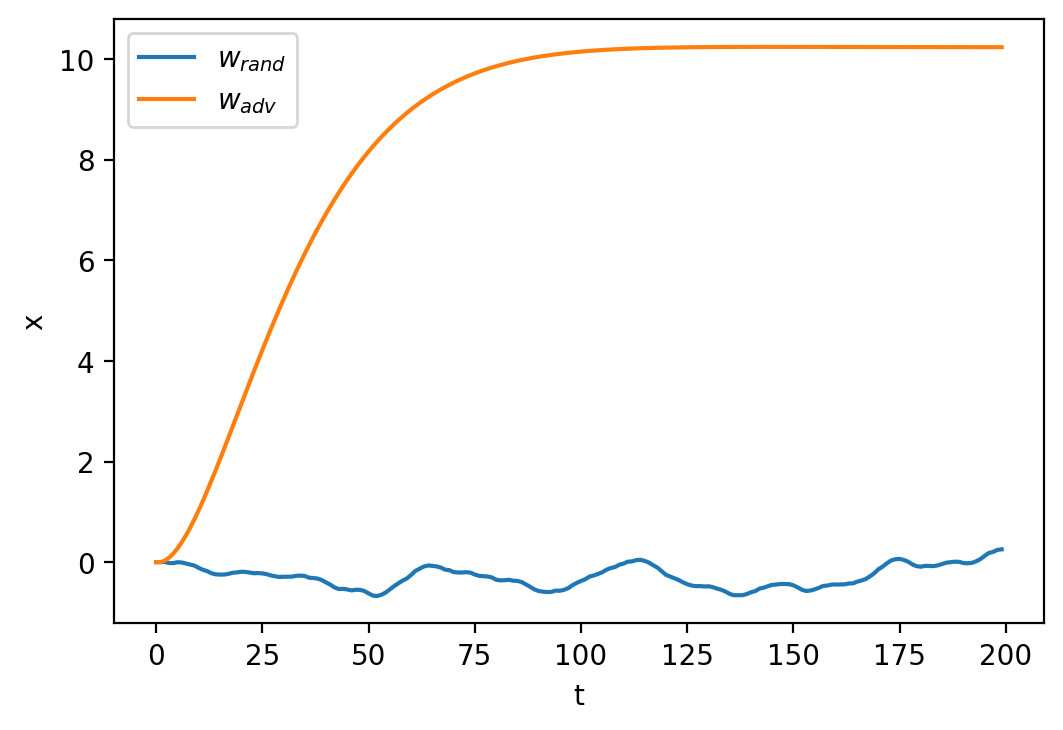

In [3]:
def evaluate(space_dim,dt,K_m_dt,l_m_dt):
    O = np.zeros((space_dim,space_dim))
    I = np.eye(space_dim)

    A = np.vstack([np.hstack([O,dt*I]),
                   np.hstack([-K_m_dt*I,-l_m_dt*I])]) + np.eye(2*space_dim)

    return  np.max(np.abs(np.linalg.eigvals(A)))

dt = 0.1
space_dim = 1
m = 1

candidate_param = np.random.rand(1000,2) * 0.1
istar = np.argmin([evaluate(space_dim,dt,K_m_dt,l_m_dt) for (K_m_dt,l_m_dt) in candidate_param])

K_star, l_star = candidate_param[istar]


K_star,l_star

K = K_star * m/dt

l = l_star*m/dt

print('Spectral radius of A:',evaluate(space_dim,dt,K_star,l_star),K,l)

x_0 = np.array([0,0]).reshape(-1,1)
time_steps = 200

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=0)


x_rand_disturbance = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_rand_disturbance.append(x)
    
    if _%100 == 0:
        print('Step',_)

env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)


x_adv_disturbance = []
# main loop
for _ in range(time_steps):
    x = env.state()
    u = 0 
        
    env.step(u)
    
    
    x_adv_disturbance.append(x)
    
    if _%100 == 0:
        print('Step',_)


# plt.plot(np.array(x_hist)[:,0],label='SafeDAP')
plt.figure(dpi=200)
plt.plot(np.array(x_rand_disturbance)[:,0],label=r'$w_{rand}$')
plt.plot(np.array(x_adv_disturbance)[:,0],label=r'$w_{adv}$')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()

In [49]:
x_0 = np.array([0,0]).reshape(-1,1)
env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l)

A = env.A
B = env.B
H = 20 # Look back length

eta_bar = 0.4 # The magnitude of exploration noise.


# Constants
x_dim = A.shape[-1]
u_dim = B.shape[-1]

I_x = np.eye(x_dim)  
I_u = np.eye(u_dim)  


w_cov = np.eye(x_dim) * env.w_max * 1/12 # Assume uniform distribution.

# Inputs to SafeDAP

Q = np.array([[1,0],
                [0,1]])*1
R = np.eye(u_dim)*1

D_x = np.vstack([I_x,-I_x]) # Constraints
# d_x = np.array([0.5,0.5,0.5,0.5])
d_x = np.array([6,6.0,6,6.0])

D_u = np.vstack([I_u,-I_u])
d_u = np.array([10,10])

w_max = env.w_max# w_max should be less than env.w_max for the problem to stay feasible.


env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)

safeDapSolver = SafeDAP(Q,R,D_x,d_x,D_u,d_u,w_max,w_cov)

M0 = np.zeros((H,u_dim,x_dim))

e_x = 0 # Usually e_x is not zero 
e_u = 0 # For safe DAP with known B, e_u = 0

n_episode = 3
refit_per_step = 20
pre_run_steps = 20
TD_steps  = 30 # The least number of steps taken in Phase 1.


x_hist = []
u_hist = []
w_hat_hist = [np.zeros((x_dim,1)) for _ in range(10*H)]

theta_hist = []
refit_time_step = []
phase1_endpoints =[]
phase2_endpoints=[]
M_hist = [M0]
r_hist = []

# The phase subroutine
def phase(eta_old,ex_old,eu_old,eta_new,ex_new,eu_new):
    M_old = M_hist[-2]
    M_new = M_hist[-1]

    theta_old = theta_hist[-2] if len(theta_hist)>1 else theta_hist[0]    
    theta_new = theta_hist[-1]

    r_old = r_hist[-2] if len(r_hist)>1 else  r_hist[0]    
    r_new = r_hist[-1]


    old = {'theta':theta_old,'r':r_old,'e_x':ex_old,'e_u':eu_old,'M':M_old,'H':H,'DM':1e-2,'eta':eta_old}
    new = {'theta':theta_new,'r':r_new,'e_x':ex_new,'e_u':eu_new,'M':M_new,'H':H,'DM':1e-2,'eta':eta_new}

    mid = safeDapSolver.mid(old,new,H)
    if any([m is None for m in mid]):# No solution, then keep mid as M_old
        mid = M_old
        print('mid is infeasible')

    transit = SafeTransit(old,new,mid)
    t = 0
    while (not transit.transit_ends()) or t<TD_steps: # Step the system for at least TD_steps, during which the SafeTransit will finish.
        if len(theta_hist)>0:
            w_hat = env.state()-transit.theta[0].dot(x_hist[-1])-transit.theta[1].dot(u_hist[-1])
            w_hat[w_hat>w_max] = 2*w_max
            w_hat[w_hat<-w_max] = -2*w_max # This is a projection. We leave it slightly loser than the true w_max
            w_hat_hist.append(w_hat) 

        x = env.state()
        x_hist.append(x)
        M,theta = transit.step()
        u = transit.get_u(w_hat_hist)# Explorative noise is automatically handled in this step.

        env.step(u)
        u_hist.append(u)
        t+=1
# main loop
for _ in range(n_episode):
    
    if _==0:
        for i in range(pre_run_steps):
            x = env.state()
            x_hist.append(x)
            u = (np.random.rand()-0.5)*2*eta_bar
            env.step(u)
            u_hist.append(u)
        A_hat,B_hat,r = ModelEst(np.array(x_hist).reshape(-1,x_dim),np.array(u_hist[:-1]).reshape(-1,u_dim),stability_gap=0.04)
        theta_hist.append((np.array(A_hat),np.array(B_hat)))
        r_hist.append(float(r))
        refit_time_step.append(len(x_hist))
        # Fit the system parameters for the first time.
    else:
        # Solve for new controller M.
        M,Phi = safeDapSolver.solve(A_hat,B_hat,H,e_x=e_x,e_u=e_u)
        if any([m is None for m in M]):# The solver does not return a feasible solution
            print('no sol')
            M=np.array(M0)
        M_hist.append(np.array(M))
        
        # Phase 1: Safe Transit with exploration
        phase_args = {'eta_old':eta_bar,'ex_old':e_x,'eu_old':e_u,
                      'eta_new':eta_bar,'ex_new':e_x,'eu_new':e_u,}
        phase(**phase_args)
        phase1_endpoints.append(len(x_hist))
        
        # Refit the system model
        A_hat,B_hat,r = ModelEst(np.array(x_hist).reshape(-1,x_dim),np.array(u_hist[:-1]).reshape(-1,u_dim),stability_gap=0.04)
        theta_hist.append((np.array(A_hat),np.array(B_hat)))
        r_hist.append(float(r))
        refit_time_step.append(len(x_hist))
        
        # Solve for new controller M.
        M,Phi = safeDapSolver.solve(A_hat,B_hat,H,e_x=0,e_u=0)
        if any([m is None for m in M]):# The solver does not return a feasible solution
            print('no sol')
            M=np.array(M0)
        M_hist.append(np.array(M))
        
        # Phase 2: SafeTransit without exploration
        phase_args = {'eta_old':eta_bar,'ex_old':e_x,'eu_old':e_u,
                      'eta_new':0,'ex_new':0,'eu_new':0,}
        phase(**phase_args)      
#         print('Phase 2 ends')
        phase2_endpoints.append(len(x_hist))
            
    
    print('Episode',_)
    

Episode 0
Episode 1
Episode 2


In [50]:
env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)

x_no_control_hist = []
# main loop
for _ in range(len(x_hist)):
    x = env.state()
    u = 0 
    env.step(u)
    
    x_no_control_hist.append(x)
    
    if _%100 == 0:
        print('Step',_)

Step 0
Step 100


In [51]:
env = SpringMass(x_0 = x_0,m=m,K_stab = K,l=l,w_adv_fraction=1)

safeDapSolver = SafeDAP(Q,R,D_x,d_x,D_u,d_u,w_max,w_cov)

e_x = 0 # Usually e_x is not zero 
e_u = 0 # For safe DAP with known B, e_u = 0
# # Pre-run steps 

x_true_hist = []
u_true_hist = []
w_true_hist = [np.zeros((x_dim,1)) for _ in range(10*H)]
time_steps = 400

pre_run_steps = 0

# M,Phi = safeDapSolver.solve(A_final,B,H,e_x=e_x,e_u=e_u)
M,Phi = safeDapSolver.solve(A,B,H,e_x=e_x,e_u=e_u)
# M,Phi = safeDapSolver.solve(theta_hist[-1][0],theta_hist[-1][1],H,e_x=e_x,e_u=e_u)
     
# main loop
for _ in range(len(x_hist)):
    x = env.state()
    x_true_hist.append(x)
    if _<pre_run_steps:
        u = (np.random.rand()-0.5)*2*eta_bar
    else:
        u = ApproxDAP(M,w_true_hist,eta_bar)

    env.step(u)
    u_true_hist.append(u)
    
    w_true_hist.append(env.state()-A.dot(x_true_hist[-1])-B.dot(u_true_hist[-1]))
    
    if _%100 == 0:
        print('Step',_)

Step 0
Step 100


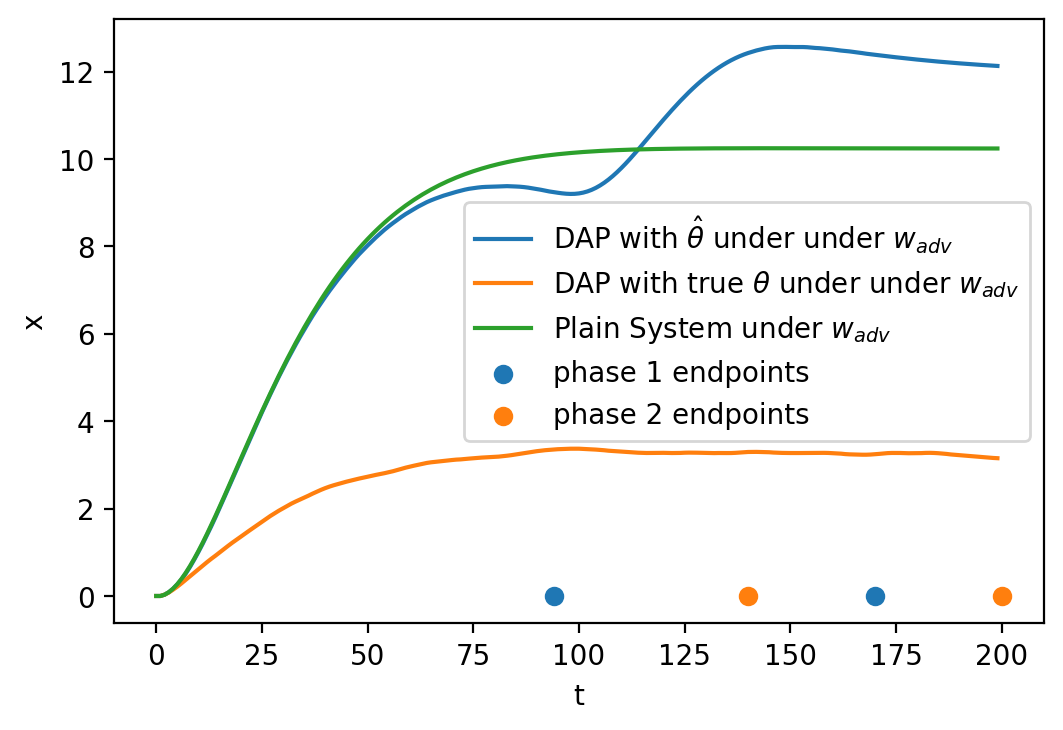

In [52]:
plt.figure(dpi=200)
plt.plot(np.array(x_hist)[:,0],label=r'DAP with $\hat{\theta}$ under under $w_{adv}$')
plt.plot(np.array(x_true_hist)[:,0],label=r'DAP with true $\theta$ under under $w_{adv}$')

plt.plot(np.array(x_no_control_hist)[:,0],label=r'Plain System under $w_{adv}$')

plt.scatter(phase1_endpoints,np.zeros(len(phase1_endpoints)),label='phase 1 endpoints')
plt.scatter(phase2_endpoints,np.zeros(len(phase2_endpoints)),label='phase 2 endpoints')


plt.xlabel('t')


plt.ylabel('x')
plt.legend()


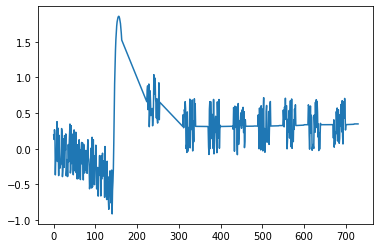

In [27]:
plt.plot(u_hist)

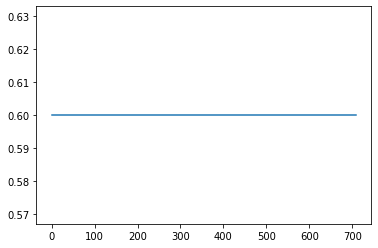

In [28]:
plt.plot(np.array(w_hat_hist[10*H:]).reshape(-1,2)[:,0])

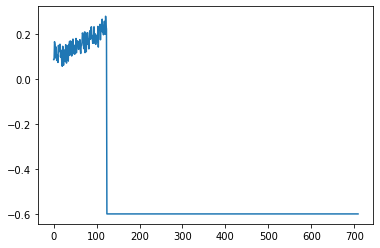

In [29]:
plt.plot(np.array(w_hat_hist[10*H:]).reshape(-1,2)[:,1])

In [30]:
refit_time_step

[20, 144, 254, 340, 400, 460, 520, 580, 640, 700]

Text(0.5, 0, '$t$')

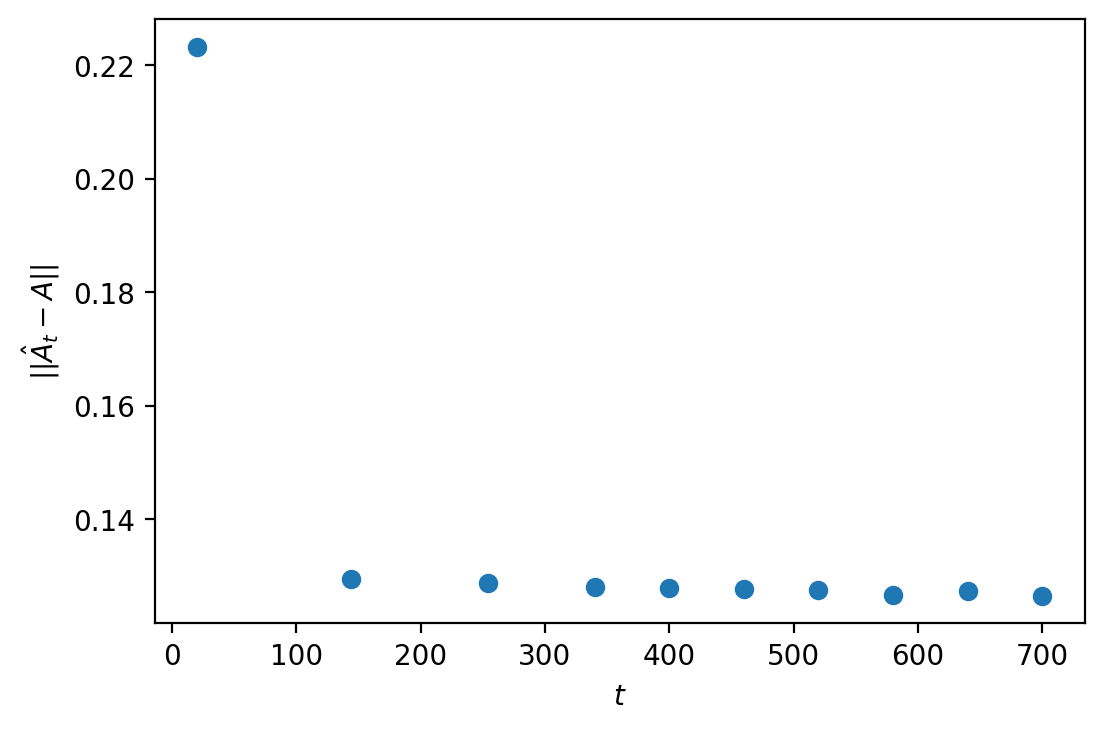

In [31]:
A_hist = np.array([m[0] for m in theta_hist])
A_diff = np.linalg.norm(A-A_hist,axis=(-1,-2))

plt.figure(dpi=200)
plt.scatter(refit_time_step,A_diff)
plt.ylabel(r'$||\hat{A}_t-A||$')
plt.xlabel(r'$t$')

Text(0.5, 0, '$t$')

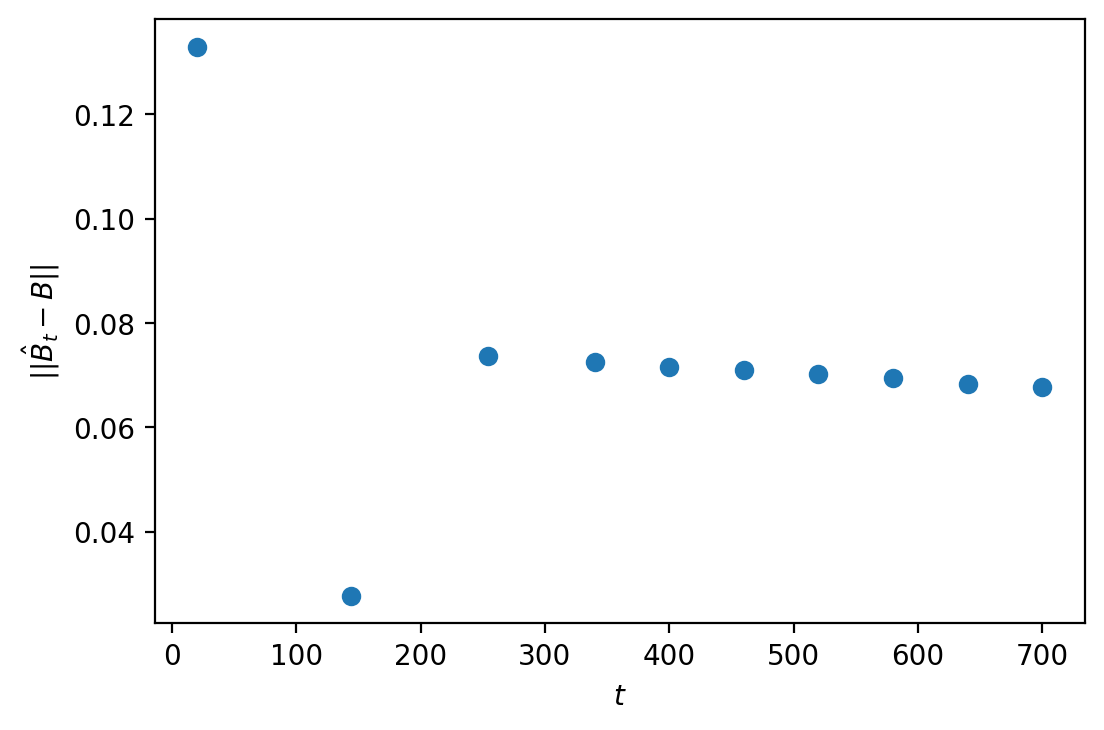

In [33]:
B_hist = np.array([m[1] for m in theta_hist])
B_diff = np.linalg.norm(B-B_hist,axis=(-1,-2))

plt.figure(dpi=200)
plt.scatter(refit_time_step,B_diff)

plt.ylabel(r'$||\hat{B}_t-B||$')
plt.xlabel(r'$t$')